# IS-4100: Simple Linear Regression (SLR) Assignment

In this assignment, you will explore the relationship between two variables using simple linear regression. You'll work with each of your eight team's data over the last year or two. You can pick any two variables you are interested in comparing. By the end of this assignment, you'll be able to:

1. Load and preprocess NFL data.
2. Perform exploratory data analysis (EDA) to understand the dataset.
3. Build and evaluate simple linear regression models.
4. Interpret the results and draw conclusions.

Be sure to submit notebook with all code cells executed or it'll be an automatic 0.

## Part 1: Environment Setup

In [1]:
install.packages('nflfastR')
install.packages('tidyverse')
install.packages('gridExtra')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘globals’, ‘listenv’, ‘parallelly’, ‘snakecase’, ‘fastrmodels’, ‘furrr’, ‘future’, ‘janitor’, ‘nflreadr’, ‘progressr’, ‘xgboost’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(nflfastR)
library(tidyverse)
library(gridExtra)
library(nflreadr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘nflreadr’


The following objects are masked from ‘package:nflfastR’:

    load_pbp, load_player_stats




In [4]:
pbp_data <- load_pbp(2016:2024)

In [40]:
season_data <- load_schedules(2016:2023)

## Part 2: EDA

The goal of this section is to invstigate potential relationships that could be used to build a SLR model with.

###Yards to Go vs Yards Gained on Passing Plays

In [6]:
# Grab only the passing data
pbp_pass <- pbp_data |>
  filter(play_type == 'pass')

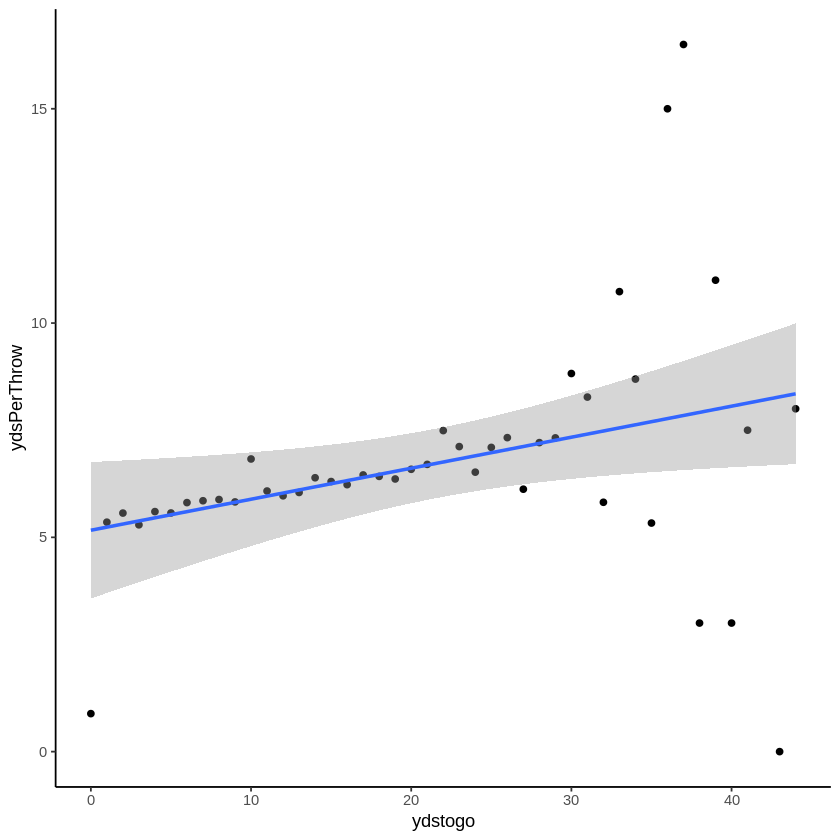

In [ ]:
# Plot to examine correlation between yards to go and yards gained on passing attempts
pbp_pass|>
  group_by(ydstogo) |>
  summarise(ydsPerThrow = mean(yards_gained)) |>
  ggplot(aes(x=ydstogo, y = ydsPerThrow)) +
    geom_point() +
    theme_classic() +
    geom_smooth(method = 'lm', formula = y ~ x)


Pretty good linear correlation up until 30 yards to go.

### Yards from Opponent Goal Line vs Yards Gained per Throw

In [ ]:
options(repr.plot.width = 18, repr.plot.height = 8)

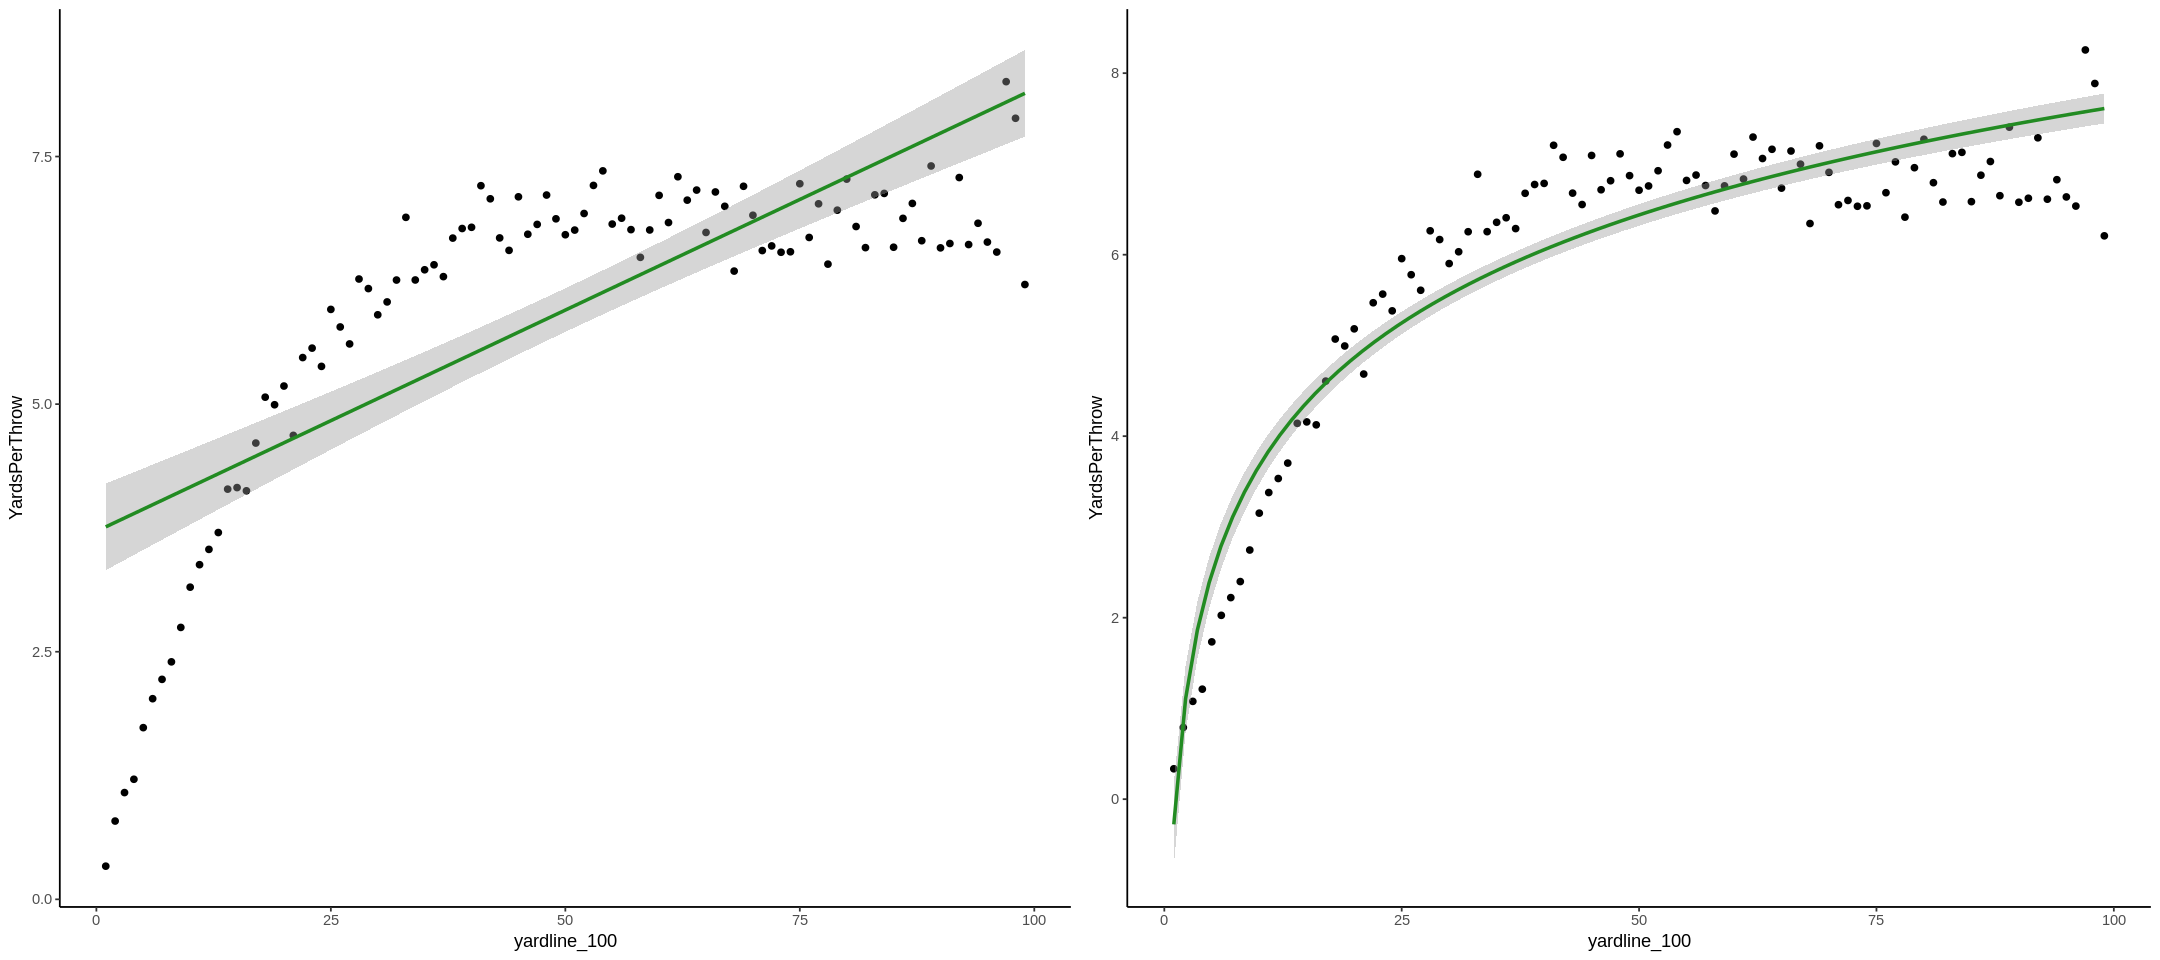

In [ ]:
plot1 <- pbp_pass |>
  group_by(yardline_100) |>
  summarise(YardsPerThrow = mean(yards_gained)) |>
  ggplot(aes(x = yardline_100, y = YardsPerThrow)) +
    geom_point() +
    geom_smooth(method = 'lm', formula = y ~ x, color = "forestgreen") +
    theme_classic()

plot2 <- pbp_pass |>
  group_by(yardline_100) |>
  summarise(YardsPerThrow = mean(yards_gained)) |>
  ggplot(aes(x = yardline_100, y = YardsPerThrow)) +
    geom_point() +
    geom_smooth(method = 'lm', formula = y~log(x), color = "forestgreen") +
    theme_classic()

  grid.arrange(plot1, plot2, ncol = 2)

A positive correlation is observed, but there is not a clear linear relationship. A logarithmic model might be better suited for this relationship.

### Score Differential vs Yards Gained on Passing Plays

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

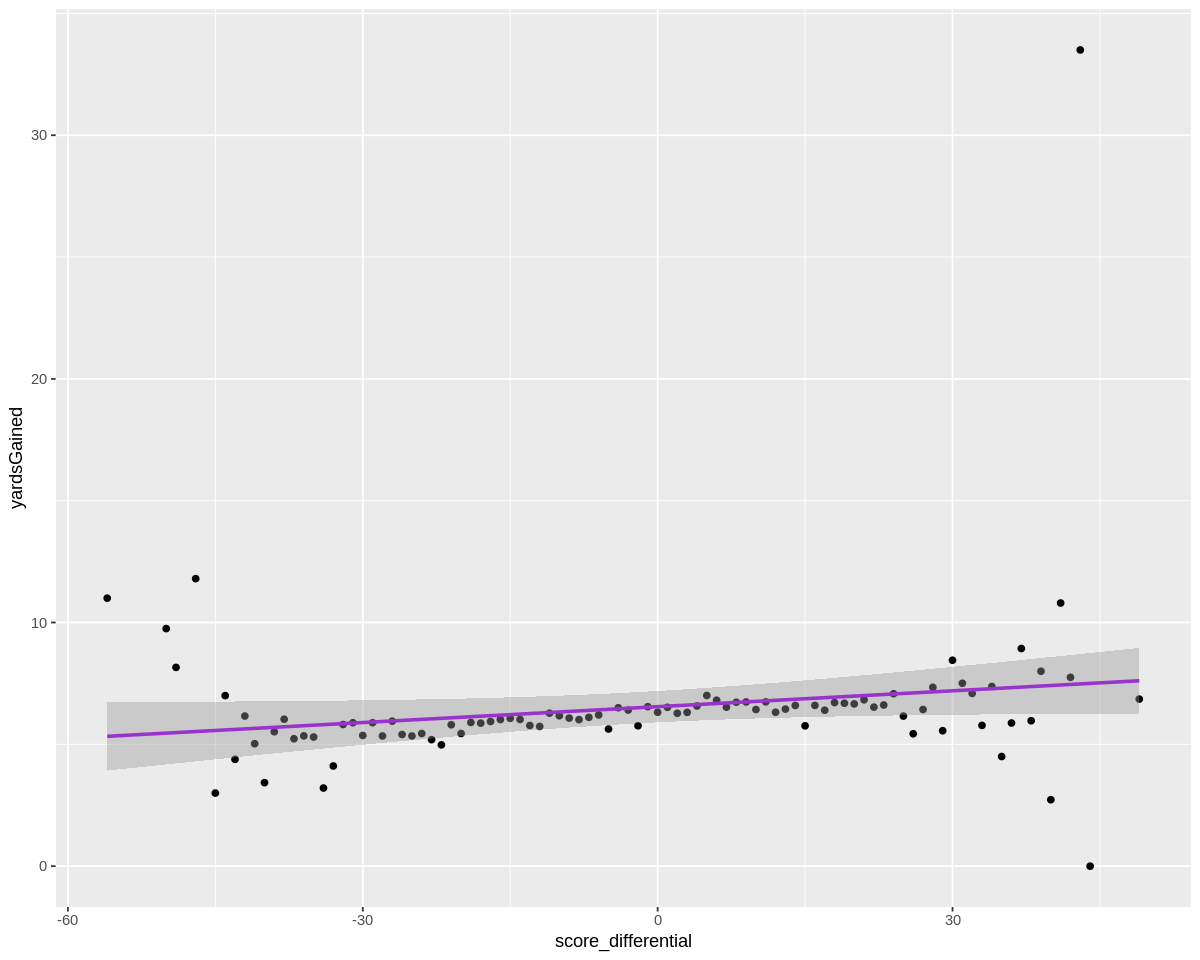

In [ ]:
pbp_pass |>
  group_by(score_differential) |>
  summarize(yardsGained = mean(yards_gained)) |>
  ggplot(aes(x = score_differential, y = yardsGained)) +
    geom_point() +
    geom_smooth(method = 'lm', formula = 'y~x', color = 'darkorchid3')

###Yards Allowed on Rushing Play vs Yards Needed to get First Down

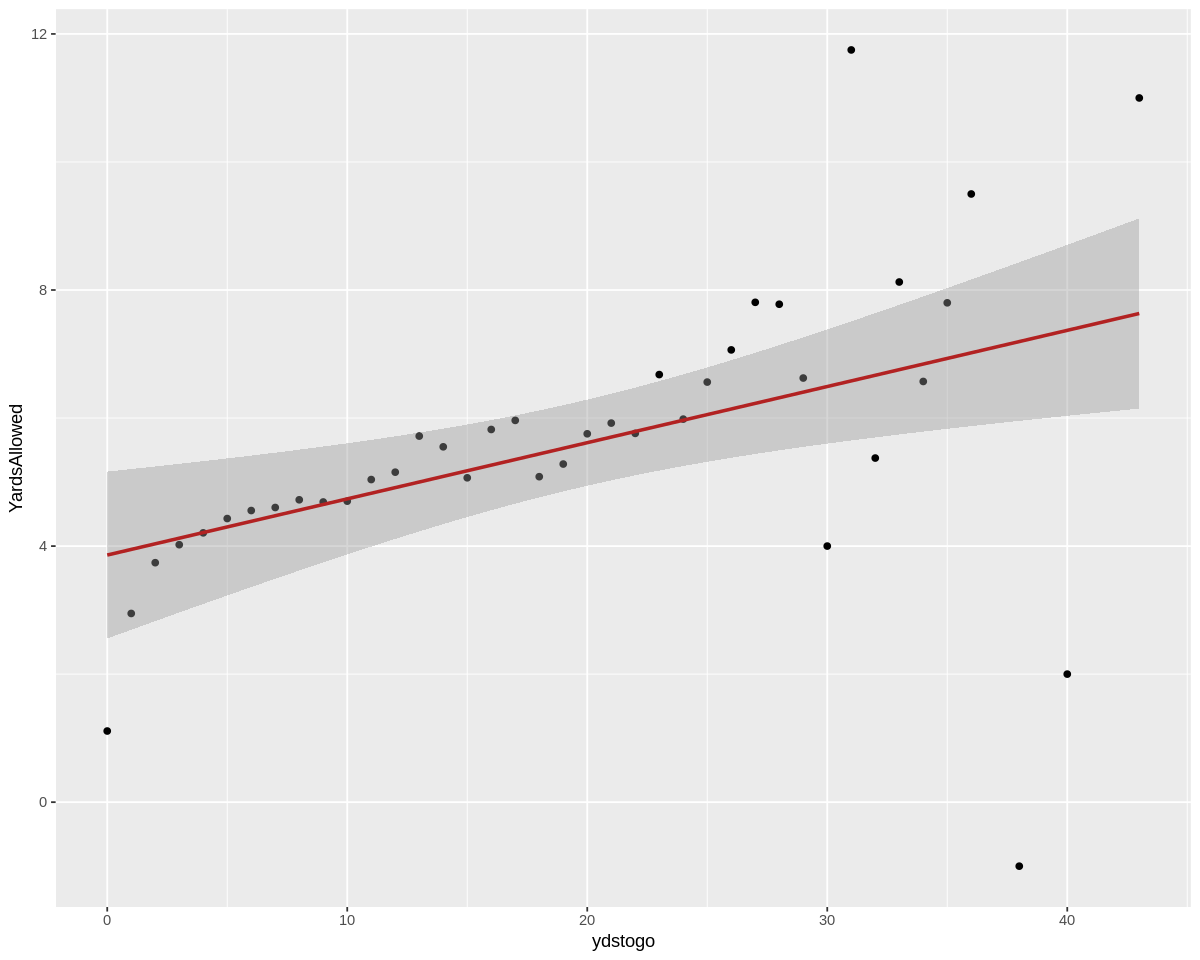

In [ ]:
pbp_data |> filter(play_type == 'run') |>
  group_by(ydstogo) |>
  summarise(YardsAllowed = mean(yards_gained)) |>
  ggplot(aes(x = ydstogo, y = YardsAllowed)) +
    geom_point() +
    geom_smooth(method = "lm", formula = "y~x", color = 'firebrick')

### Points Allowed and Points Scored vs Win Percentage

In [ ]:
#Create vector of teams and seasons
teams <- unique(season_data$home_team)
seasons <- unique(season_data$season)

In [ ]:
# Create Custom Data Frame
records <- data.frame(Team = character(), Season = integer(), Wins = integer(), Losses = integer(), Average_Points_Scored = double(),
                      Average_Points_Allowed = double(), Win_Percentage = double())


In [ ]:
# Initialize records data frame
records <- data.frame()

for (team in teams) {
  currentTeam <- season_data %>%
    filter(home_team == team | away_team == team)

  for (s in seasons) {
    currentSeason <- currentTeam %>%
      filter(season == s)

    # Calculate wins, losses, points allowed, and points scored
    stats <- currentSeason %>%
      summarise(
        Wins = sum((home_team == team & home_score > away_score) | (away_team == team & away_score > home_score)),
        Losses = sum((home_team == team & home_score < away_score) | (away_team == team & away_score < home_score)),
        Points_Scored = sum(ifelse(home_team == team, home_score, away_score)),
        Points_Allowed = sum(ifelse(home_team == team, away_score, home_score))
      )

    games_played <- stats$Wins + stats$Losses

    # Calculate averages and win percentage
    if (games_played > 0) {
      ppg <- stats$Points_Scored / games_played
      pa <- stats$Points_Allowed / games_played
      wp <- stats$Wins / games_played
    } else {
      ppg <- 0
      pa <- 0
      wp <- 0
    }

    newRow <- data.frame(Team = team, Season = s, Wins = stats$Wins, Losses = stats$Losses,
              Average_Points_Scored = ppg, Average_Points_Allowed = pa, Win_Percentage = wp)

    records <- rbind(records, newRow)

  }
}



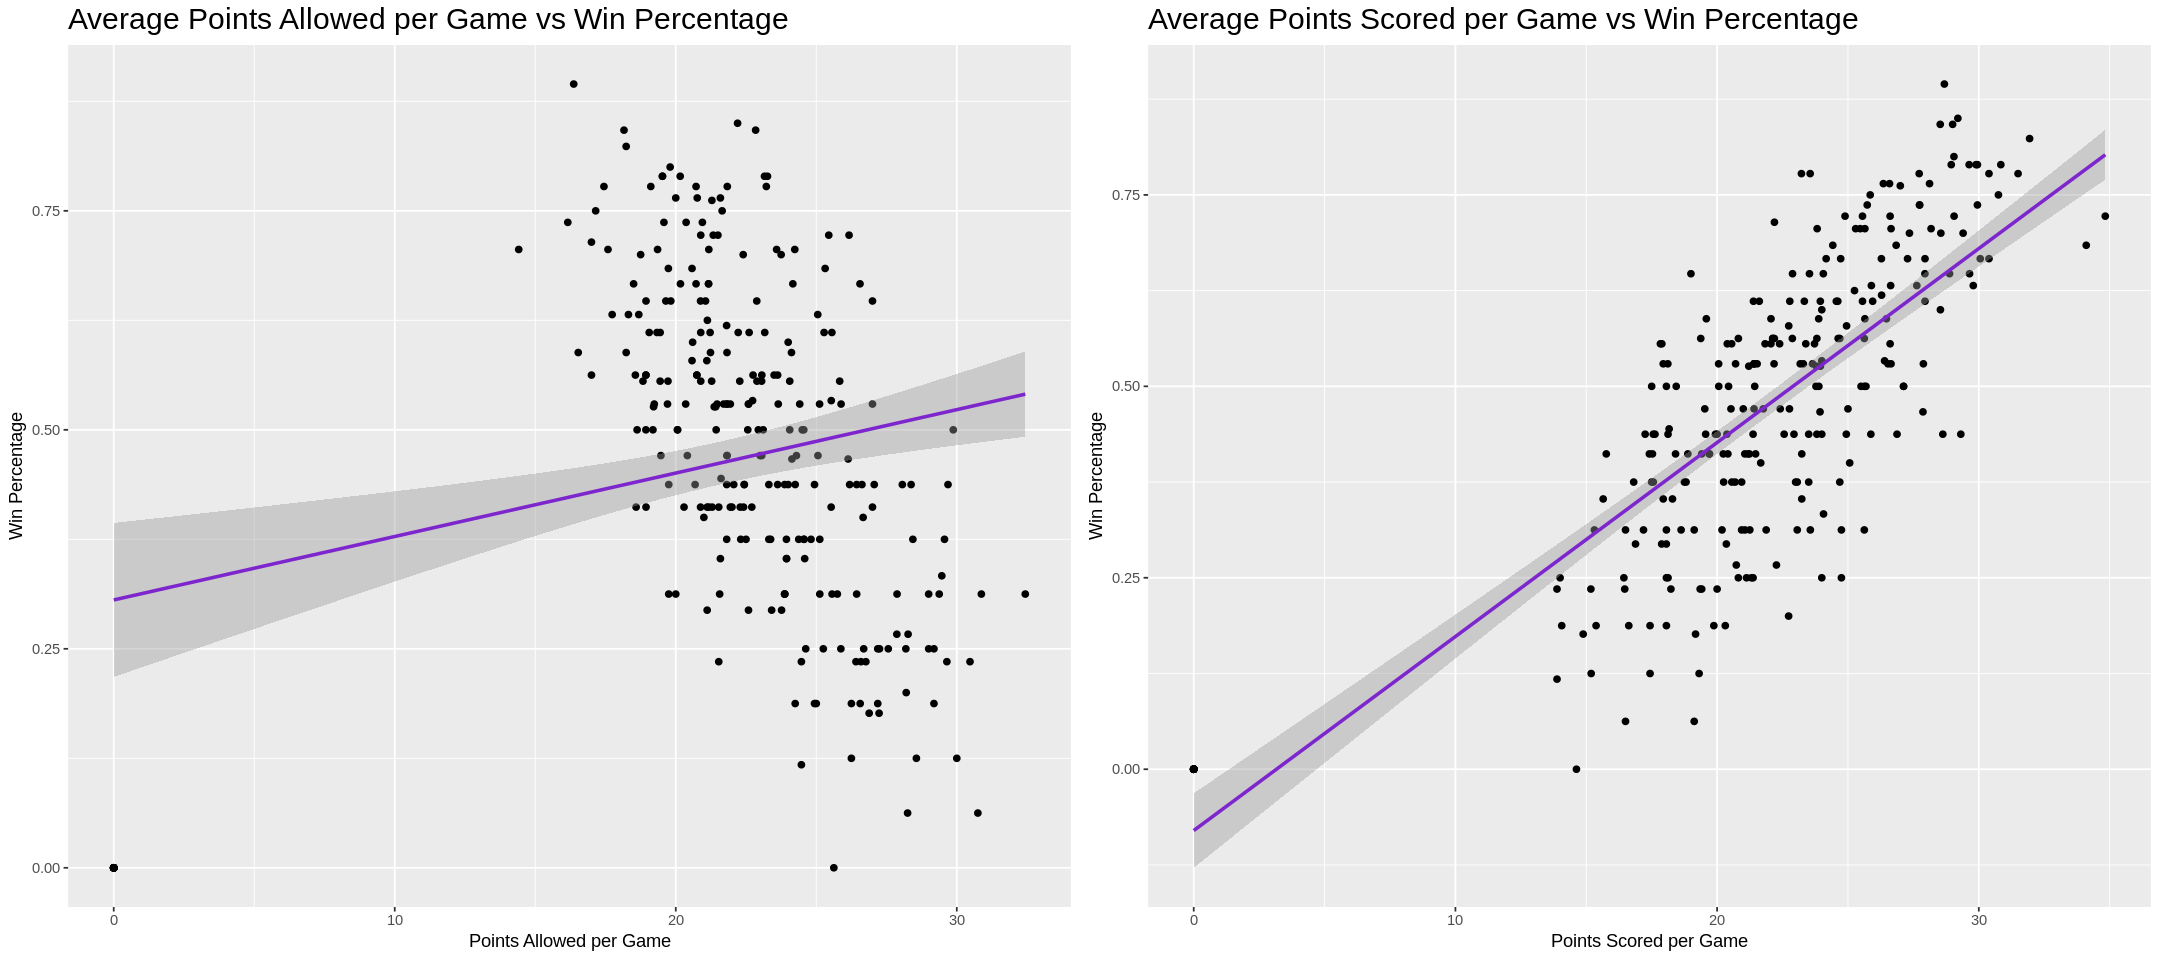

In [ ]:
options(repr.plot.width = 18, repr.plot.height = 8)

plot1 <- records |>
  ggplot(aes(x = Average_Points_Allowed, y = Win_Percentage)) +
    geom_point() +
    geom_smooth(method = 'lm', formula = 'y~x', color = 'purple3') +
    labs(
      x = 'Points Allowed per Game',
      y = 'Win Percentage',
      title = 'Average Points Allowed per Game vs Win Percentage'
    ) +
    theme(plot.title = element_text(size =  18))

plot2 <-  records |>
  ggplot(aes(x = Average_Points_Scored, y = Win_Percentage)) +
    geom_point() +
    geom_smooth(method = 'lm', formula = 'y~x', color = 'purple3') +
    labs(
      x = 'Points Scored per Game',
      y = 'Win Percentage',
      title = 'Average Points Scored per Game vs Win Percentage'
    ) +
    theme(plot.title = element_text(size =  18))

grid.arrange(plot1, plot2, ncol = 2)

Doesn't appear to be much of a correlation between points allowed per game and win percentage. However, there appears to be a positive correlation between Points scored per game and win percentage.

## Part 3: Build SLR Models

In [7]:
#Build the SLR Model
#Passing Yards Gained vs Yards to Go

baseModel <- lm(yards_gained ~ 1 + ydstogo, data = pbp_pass)
summary(baseModel)



Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = pbp_pass)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.581  -6.372  -2.372   3.732  91.628 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.328248   0.059442   89.64   <2e-16 ***
ydstogo     0.104403   0.006114   17.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.965 on 164946 degrees of freedom
Multiple R-squared:  0.001765,	Adjusted R-squared:  0.001759 
F-statistic: 291.6 on 1 and 164946 DF,  p-value: < 2.2e-16


### Bengals

#### Base Model

In [20]:
teamdf <- pbp_pass |> filter(posteam == 'CIN')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.159  -6.159  -2.286   3.841  80.326 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.18888    0.33861  15.324  < 2e-16 ***
ydstogo      0.09701    0.03503   2.769  0.00564 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.05 on 5299 degrees of freedom
Multiple R-squared:  0.001445,	Adjusted R-squared:  0.001256 
F-statistic: 7.667 on 1 and 5299 DF,  p-value: 0.005643


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [29]:
newdf <- pbp_pass |> filter(posteam == 'CIN' & defteam == 'CAR')
summary(lm(yards_gained ~ 1 + ydstogo, data = newdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = newdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.458  -6.720  -1.894   4.019  41.670 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  6.10897    2.58804   2.360   0.0208 *
ydstogo      0.08722    0.25608   0.341   0.7343  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.518 on 78 degrees of freedom
Multiple R-squared:  0.001485,	Adjusted R-squared:  -0.01132 
F-statistic: 0.116 on 1 and 78 DF,  p-value: 0.7343


Only the intercept term is significant, but the ydstogo variable is not.

### Colts

#### Base Model

In [31]:
teamdf <- pbp_pass |> filter(posteam == 'IND')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.508  -6.251  -2.380   3.749  73.878 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.96145    0.33296  14.901  < 2e-16 ***
ydstogo      0.12891    0.03403   3.789 0.000153 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.668 on 4983 degrees of freedom
Multiple R-squared:  0.002872,	Adjusted R-squared:  0.002672 
F-statistic: 14.35 on 1 and 4983 DF,  p-value: 0.0001532


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [32]:
teamdf <- pbp_pass |> filter(posteam == 'IND' & defteam == 'PIT')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.159  -5.932  -2.932   3.252  55.068 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   4.7925     1.7545   2.732  0.00684 **
ydstogo       0.1139     0.1804   0.631  0.52844   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.55 on 209 degrees of freedom
Multiple R-squared:  0.001904,	Adjusted R-squared:  -0.002871 
F-statistic: 0.3987 on 1 and 209 DF,  p-value: 0.5284


Only the intercept term is a significant predictor in this model.

### Cheifs

#### Base Model

In [22]:
teamdf <- pbp_pass |> filter(posteam == 'KC')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.525  -7.127  -2.260   3.740  81.740 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.93524    0.33203  17.876  < 2e-16 ***
ydstogo      0.13247    0.03465   3.823 0.000133 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.47 on 5924 degrees of freedom
Multiple R-squared:  0.002461,	Adjusted R-squared:  0.002292 
F-statistic: 14.61 on 1 and 5924 DF,  p-value: 0.0001334


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [33]:
teamdf <- pbp_pass |> filter(posteam == 'KC' & defteam == 'ATL')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.882  -7.123  -1.824   4.912  26.647 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   3.2947     2.8658   1.150    0.254
ydstogo       0.5058     0.3080   1.642    0.105

Residual standard error: 8.994 on 69 degrees of freedom
Multiple R-squared:  0.03761,	Adjusted R-squared:  0.02366 
F-statistic: 2.696 on 1 and 69 DF,  p-value: 0.1051


Neither are significant predictors now.

### Patriots

#### Base Model

In [23]:
teamdf <- pbp_pass |> filter(posteam == 'NE')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.727  -6.727  -2.611   4.203  72.273 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.86685    0.34349  14.169  < 2e-16 ***
ydstogo      0.18600    0.03576   5.201 2.05e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.739 on 5253 degrees of freedom
Multiple R-squared:  0.005124,	Adjusted R-squared:  0.004934 
F-statistic: 27.05 on 1 and 5253 DF,  p-value: 2.054e-07


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [34]:
teamdf <- pbp_pass |> filter(posteam == 'NE' & defteam == 'SF')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.263  -6.263  -2.298   3.764  49.727 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  6.312378   3.308729   1.908   0.0608 .
ydstogo     -0.004957   0.350372  -0.014   0.9888  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.671 on 65 degrees of freedom
Multiple R-squared:  3.079e-06,	Adjusted R-squared:  -0.01538 
F-statistic: 0.0002001 on 1 and 65 DF,  p-value: 0.9888


### Eagles

#### Base Model

In [24]:
teamdf <- pbp_pass |> filter(posteam == 'PHI')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.196  -6.297  -2.588   3.804  84.703 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.28378    0.32594  16.211  < 2e-16 ***
ydstogo      0.10134    0.03332   3.042  0.00236 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.878 on 5411 degrees of freedom
Multiple R-squared:  0.001707,	Adjusted R-squared:  0.001522 
F-statistic: 9.251 on 1 and 5411 DF,  p-value: 0.002365


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [35]:
teamdf <- pbp_pass |> filter(posteam == 'PHI' & defteam == 'TB')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.106  -5.989  -3.288   3.076  49.245 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   4.8202     1.5263   3.158  0.00183 **
ydstogo       0.1169     0.1468   0.796  0.42675   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.746 on 199 degrees of freedom
Multiple R-squared:  0.003177,	Adjusted R-squared:  -0.001832 
F-statistic: 0.6343 on 1 and 199 DF,  p-value: 0.4267


### Vikings

#### Base Model

In [25]:
teamdf <- pbp_pass |> filter(posteam == 'MIN')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.329  -6.572  -2.288   3.806  90.428 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.72051    0.31785  17.997  < 2e-16 ***
ydstogo      0.09464    0.03255   2.907  0.00366 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.987 on 5198 degrees of freedom
Multiple R-squared:  0.001624,	Adjusted R-squared:  0.001431 
F-statistic: 8.453 on 1 and 5198 DF,  p-value: 0.00366


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [36]:
teamdf <- pbp_pass |> filter(posteam == 'MIN' & defteam == 'GB')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.828  -6.828  -2.269   3.801  68.172 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.4296     1.0079   5.387 1.04e-07 ***
ydstogo       0.1399     0.1033   1.354    0.176    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.8 on 577 degrees of freedom
Multiple R-squared:  0.003166,	Adjusted R-squared:  0.001439 
F-statistic: 1.833 on 1 and 577 DF,  p-value: 0.1763


### Saints

#### Base Model

In [26]:
teamdf <- pbp_pass |> filter(posteam == 'NO')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.080  -6.789  -2.080   3.920  90.920 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.62520    0.35407  15.887  < 2e-16 ***
ydstogo      0.14548    0.03709   3.922 8.88e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.09 on 5016 degrees of freedom
Multiple R-squared:  0.003058,	Adjusted R-squared:  0.002859 
F-statistic: 15.39 on 1 and 5016 DF,  p-value: 8.885e-05


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [38]:
teamdf <- pbp_pass |> filter(posteam == 'NO' & defteam == 'ATL')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.350  -6.625  -2.118   3.625  62.115 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.65313    0.95928   4.851 1.58e-06 ***
ydstogo      0.24647    0.09896   2.491    0.013 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.743 on 590 degrees of freedom
Multiple R-squared:  0.01041,	Adjusted R-squared:  0.008728 
F-statistic: 6.204 on 1 and 590 DF,  p-value: 0.01302


Both predictors are actually significant.

### Cardinals

#### Base Model

In [27]:
teamdf <- pbp_pass |> filter(posteam == 'ARI')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.619  -5.766  -2.521   3.528  82.332 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.27651    0.31391  16.809   <2e-16 ***
ydstogo      0.04893    0.03151   1.553    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.526 on 5159 degrees of freedom
Multiple R-squared:  0.0004671,	Adjusted R-squared:  0.0002733 
F-statistic: 2.411 on 1 and 5159 DF,  p-value: 0.1206


Both the intercept term and ydstogo are significant predictors, but this model has a low R Squared Value.

#### Opponent Specific Model

In [39]:
teamdf <- pbp_pass |> filter(posteam == 'ARI' & defteam == 'WAS')
summary(lm(yards_gained ~ 1 + ydstogo, data = teamdf))


Call:
lm(formula = yards_gained ~ 1 + ydstogo, data = teamdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.386  -4.857  -3.762   2.832  49.143 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  3.91512    1.63216   2.399   0.0174 *
ydstogo      0.09414    0.16985   0.554   0.5800  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.325 on 201 degrees of freedom
Multiple R-squared:  0.001526,	Adjusted R-squared:  -0.003441 
F-statistic: 0.3072 on 1 and 201 DF,  p-value: 0.58


## Part 4: Interpretation and Discussion

In terms of the base model that included data from all teams, the intercept term and the ydstogo predictor were significant meaning that an increase in yards gained was associated with an increase in the yards needed to get a first down. However, this model has very little predicting power which is illustrated by an adjusted R squared value of .001.

When looking at team specific data, the ydstogo predictor lost significance, and a low adjusted r squared was observed.

Overall, these models help prove the associateion between an increase in yards gained as the yards needed to gain a first down increases, but these models shouldn't not be used in predictions. In order to more accurately predict the yards gained field a more sophisticated model would be needed. Using a SLR model to predict yards gained is simply insufficient.